# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist

from aux_functions import compute_bic 

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import optuna

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('./data/azdias.csv', sep=';', index_col=0)
customers = pd.read_csv('./data/customers.csv', sep=';', index_col=0)

In [3]:
azdias.shape

(891221, 366)

In [4]:
customers.shape

(191652, 369)

### Taking a look at the customers data

In [5]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [6]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


### Getting attributes to replace unknown values with NaN
Filled values may actually be a label to unknown, what would be the equivalent to having a missing value instead

In [3]:
attributes = pd.read_excel(r'./data/DIAS Attributes - Values 2017.xlsx', skiprows=1).iloc[:,1:]

In [6]:
# Taking a look at the dataframe
attributes.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly


In [7]:
# Looking for unkown and missing data labels
attributes.loc[attributes['Meaning'].str.contains('known')==True, 'Meaning'].value_counts()

unknown                                                           232
no transaction known                                               34
no transactions known                                              22
mixed building without actually known company                       1
residental building buildings without actually known household      1
mixed building without actually known household                     1
unknown / no main age detectable                                    1
mixed building without actually known household or comapny          1
company building w/o known company                                  1
Name: Meaning, dtype: int64

In [4]:
def get_unknown(attritutes: pd.DataFrame) -> pd.DataFrame:
    '''
    Function to detect unkown code values from the attributes dataset
    '''

    na = attributes.ffill()
    na = na.loc[(na['Meaning'].str.contains('unknown')) | (na['Meaning'] == 'no transaction known') | (na['Meaning'] == 'no transactions known')]
    na = pd.concat([pd.Series(row['Attribute'], str(row['Value']).split(',')) for _, row in na.iterrows()]).reset_index()
    na.rename(columns={'index':'Value', 0: 'Attribute'}, inplace = True)
    return na

In [5]:
# Getting the NA values from the attributes dataset
attribute_na = get_unknown(attributes)

In [6]:
# Replacing NaN values in the customers dataset
for column in customers.columns:
    na_values = attribute_na.loc[attribute_na['Attribute'] == column, 'Value'].values
    customers.loc[customers[column].isin(na_values), column] = np.NaN

Now the number of NaN values per column and rows can be properly seen

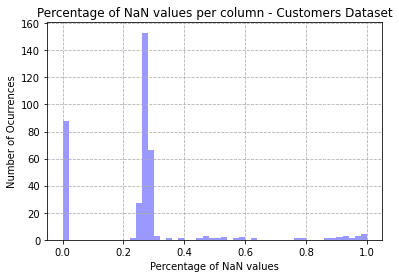

In [12]:
sns.distplot(customers.isna().sum()/len(customers.index), kde=False, color = 'b')
plt.title('Percentage of NaN values per column - Customers Dataset')
plt.xlabel('Percentage of NaN values')
plt.ylabel('Number of Ocurrences')
plt.grid(linestyle='dashed')
plt.show()

In [7]:
# NAs per column
(customers.isna().sum()/len(customers.index)).describe()

count    369.000000
mean       0.247582
std        0.197485
min        0.000000
25%        0.243128
50%        0.267574
75%        0.292102
max        0.998769
dtype: float64

In [8]:
# NAs per row
(customers.isna().sum(axis=1)/len(customers.columns)).describe()

count    191652.000000
mean          0.247582
std           0.305236
min           0.005420
25%           0.048780
50%           0.065041
75%           0.655827
max           0.775068
dtype: float64

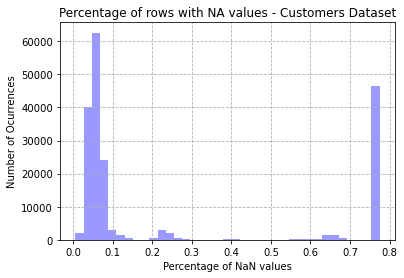

In [18]:
sns.distplot(customers.isna().sum(axis=1)/len(customers.columns), kde=False, color='blue')
plt.title('Percentage of rows with NA values - Customers Dataset')
plt.xlabel('Percentage of NaN values')
plt.ylabel('Number of Ocurrences')
plt.grid(linestyle='dashed')
plt.show()

### Checking consistency between columns in customers as azdias dataset

In [20]:
[x for x in customers.columns if x not in list(azdias.columns)]

['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']

In [7]:
# As the different columns are referent only to customer information the analysis will continue with the common columns between the datasets
customers = customers[[x for x in customers.columns if x in list(azdias.columns)]]

In [16]:
# checking for data types
customers.dtypes.value_counts()

float64    360
object       6
dtype: int64

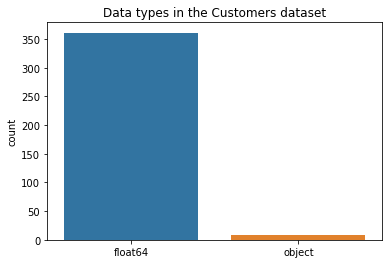

In [8]:
sns.countplot(list(customers.dtypes.values.astype(str)))
plt.title('Data types in the Customers dataset')
plt.show()

In [24]:
customers.dtypes.sort_values().tail(6)

D19_LETZTER_KAUF_BRANCHE    object
CAMEO_DEU_2015              object
CAMEO_DEUG_2015             object
CAMEO_INTL_2015             object
EINGEFUEGT_AM               object
OST_WEST_KZ                 object
dtype: object

In [25]:
# printing the columns in the dataframe
customers[[x for x in customers.dtypes.sort_values().tail(6).index]].head()

,D19_LETZTER_KAUF_BRANCHE,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,EINGEFUEGT_AM,OST_WEST_KZ
0,D19_UNBEKANNT,1A,1,13,1992-02-12 00:00:00,W
1,D19_BANKEN_GROSS,NaN,NaN,NaN,NaN,NaN
2,D19_UNBEKANNT,5D,5,34,1992-02-10 00:00:00,W
3,D19_NAHRUNGSERGAENZUNG,4C,4,24,1992-02-10 00:00:00,W
4,D19_SCHUHE,7B,7,41,1992-02-12 00:00:00,W


In [26]:
# getting the categorical features meanings
attributes.loc[attributes['Attribute'].isin([x for x in customers.dtypes.sort_values().tail(6).index])]

,Attribute,Description,Value,Meaning
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
61,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1A,Work-Life-Balance
2013,OST_WEST_KZ,flag indicating the former GDR/FRG,-1,unknown


In [27]:
customers['OST_WEST_KZ'].value_counts()

W    130382
O     11343
Name: OST_WEST_KZ, dtype: int64

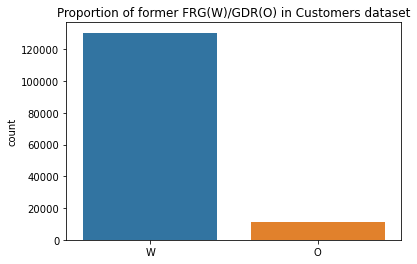

In [12]:
sns.countplot(customers['OST_WEST_KZ'])
plt.title('Proportion of former FRG(W)/GDR(O) in Customers dataset')
plt.xlabel('')
plt.show()

### Taking a look at the AZDIAS dataset

In [13]:
azdias.dtypes.sort_values()

LNR                          int64
D19_WEIN_FEINKOST            int64
D19_VOLLSORTIMENT            int64
D19_VERSICHERUNGEN           int64
D19_VERSI_ONLINE_DATUM       int64
                             ...  
OST_WEST_KZ                 object
D19_LETZTER_KAUF_BRANCHE    object
CAMEO_INTL_2015             object
CAMEO_DEU_2015              object
CAMEO_DEUG_2015             object
Length: 366, dtype: object

In [13]:
for column in azdias.columns:
    try:
        na_values = attribute_na.loc[attribute_na['Attribute'] == column, 'Value'].values
        azdias.loc[azdias[column].isin(na_values), column] = np.NaN
    except:
        pass

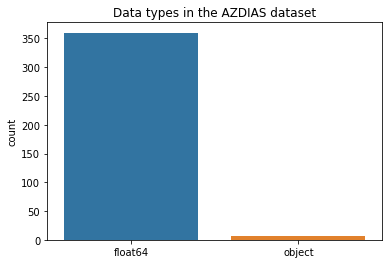

In [14]:
sns.countplot(list(azdias.dtypes.values.astype(str)))
plt.title('Data types in the AZDIAS dataset')
plt.show()

In [10]:
num_nas_azdias = (azdias.isna().sum()/len(azdias.index))

In [16]:
num_nas_azdias.sort_values(ascending=False).head(15)

ALTER_KIND4                    0.998648
TITEL_KZ                       0.997576
ALTER_KIND3                    0.993077
ALTER_KIND2                    0.966900
ALTER_KIND1                    0.909048
AGER_TYP                       0.760196
EXTSEL992                      0.733996
KK_KUNDENTYP                   0.655967
KBA05_BAUMAX                   0.534687
ALTER_HH                       0.348137
ALTERSKATEGORIE_FEIN           0.295041
D19_KONSUMTYP                  0.288495
D19_LETZTER_KAUF_BRANCHE       0.288495
D19_VERSAND_ONLINE_QUOTE_12    0.288495
D19_LOTTO                      0.288495
dtype: float64

In [11]:
num_nas_azdias.describe()

count    366.000000
mean       0.158997
std        0.206348
min        0.000000
25%        0.082470
50%        0.118714
75%        0.166188
max        0.998648
dtype: float64

In [12]:
(azdias.isna().sum(axis=1)/len(azdias.columns)).describe()

count    891221.000000
mean          0.158997
std           0.213004
min           0.008197
25%           0.054645
50%           0.076503
75%           0.112022
max           0.781421
dtype: float64

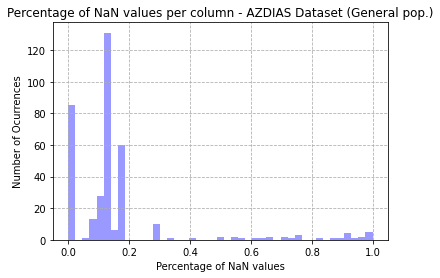

In [7]:
sns.distplot(azdias.isna().sum()/len(azdias.index), kde=False, color = 'b')
plt.title('Percentage of NaN values per column - AZDIAS Dataset (General pop.)')
plt.xlabel('Percentage of NaN values')
plt.ylabel('Number of Ocurrences')
plt.grid(linestyle='dashed')
plt.show()

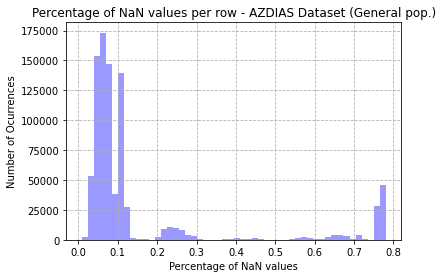

In [19]:
sns.distplot(azdias.isna().sum(axis=1)/len(azdias.columns), kde=False, color = 'b')
plt.title('Percentage of NaN values per row - AZDIAS Dataset (General pop.)')
plt.xlabel('Percentage of NaN values')
plt.ylabel('Number of Ocurrences')
plt.grid(linestyle='dashed')
plt.show()

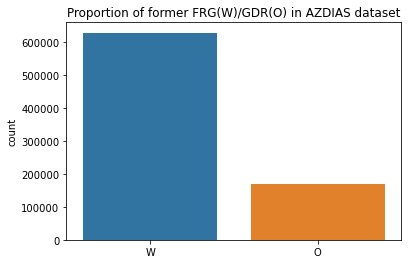

In [20]:
sns.countplot(azdias['OST_WEST_KZ'])
plt.title('Proportion of former FRG(W)/GDR(O) in AZDIAS dataset')
plt.xlabel('')
plt.show()

In [22]:
num_nas_azdias_row.describe()

count    891221.000000
mean          0.113700
std           0.208205
min           0.002732
25%           0.019126
50%           0.024590
75%           0.051913
max           0.721311
dtype: float64

In [30]:
num_nas_azdias.quantile(0.95)

0.2884952217239046

In [33]:
num_nas_azdias_row.quantile(0.95)

0.7076502732240437

From the graph and statistics about the NA values, the threshold of 29% os NAs will be used to drop them.

### Assessing categorical values

In [38]:
azdias.dtypes.drop_duplicates()

LNR               float64
CAMEO_DEU_2015     object
dtype: object

In [35]:
azdias.dtypes.sort_values().tail(10)

KBA05_ALTER2                float64
KBA05_ALTER1                float64
INNENSTADT                  float64
KBA05_ANTG1                 float64
D19_LETZTER_KAUF_BRANCHE     object
CAMEO_DEU_2015               object
CAMEO_DEUG_2015              object
CAMEO_INTL_2015              object
EINGEFUEGT_AM                object
OST_WEST_KZ                  object
dtype: object

In [14]:
# Checking for number of unique values
for i in azdias.dtypes.sort_values().tail(6).index:
    print(f'Feature {i} has {azdias[i].nunique()} values')

Feature D19_LETZTER_KAUF_BRANCHE has 35 values
Feature CAMEO_DEU_2015 has 45 values
Feature CAMEO_DEUG_2015 has 19 values
Feature CAMEO_INTL_2015 has 43 values
Feature EINGEFUEGT_AM has 5162 values
Feature OST_WEST_KZ has 2 values


In [13]:
azdias.corr()

In [44]:
# Looking at the values in each column
for i in azdias.dtypes.sort_values().tail(6).index:
    print(f'Feature: {i}')
    print(azdias[i].value_counts())

Feature: D19_LETZTER_KAUF_BRANCHE
D19_UNBEKANNT             195338
D19_VERSICHERUNGEN         57734
D19_SONSTIGE               44722
D19_VOLLSORTIMENT          34812
D19_SCHUHE                 32578
D19_BUCH_CD                28754
D19_VERSAND_REST           26034
D19_DROGERIEARTIKEL        24072
D19_BANKEN_DIREKT          23273
D19_BEKLEIDUNG_REST        21796
D19_HAUS_DEKO              20858
D19_TELKO_MOBILE           14447
D19_ENERGIE                12084
D19_TELKO_REST             11472
D19_BANKEN_GROSS           10550
D19_BEKLEIDUNG_GEH         10272
D19_KINDERARTIKEL           7301
D19_FREIZEIT                7257
D19_TECHNIK                 7002
D19_LEBENSMITTEL            6458
D19_BANKEN_REST             5247
D19_RATGEBER                4931
D19_NAHRUNGSERGAENZUNG      4061
D19_DIGIT_SERV              3577
D19_REISEN                  3122
D19_TIERARTIKEL             2578
D19_SAMMELARTIKEL           2443
D19_HANDWERK                2227
D19_WEIN_FEINKOST           2164
D19_GARTE

Approach by column:
* D19_LETZTER_KAUF_BRANCHE: Columns will be dropped, as categories are many and last purchase sector may be more situational that may not reflect the potential customer's profile;
* CAMEO_DEU_2015: String rows seem like input error, will be treated as NAs;
* CAMEO_DEUG_2015: String rows seem like input error, will be treated as NAs;
* CAMEO_INTL_2015: String rows seem like input error, will be treated as NAs;
* EINGEFUEGT_AM: Input date will be dropped;
* OST_WEST_KZ: As there are only two categories, W will be replaced by 0 and O by 1.


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [22]:
# Taking the data exploration step and converting it's conclusion to a preprocessing function

def pre_process_df(df: pd.DataFrame, columns: list, attributes: pd.DataFrame, filter_na: bool = True) -> pd.DataFrame:

    '''
    This function takes the raw dataset and filter columns and rows out to output a pre-processed dataframe
    '''

    attribute_na = get_unknown(attributes)

    if filter_na:
        columns_keep = []
        for column in columns:
            na_values = attribute_na.loc[attribute_na['Attribute'] == column, 'Value'].values
            df.loc[df[column].isin(na_values), column] = np.NaN
            if (df[column].isna().sum()/len(df[column])) <= 0.29:
                columns_keep.append(column)

        df = df[columns_keep]
        df.drop(columns = ['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'CAMEO_DEU_2015'], inplace = True)
    else:
        
        df = df[columns]

    df['cut_row'] = df.isna().sum(axis=1)/df.shape[1]
    df = df.loc[df['cut_row'] <= 0.51] # mean + 2 stdev
    df.drop(columns = ['cut_row', 'LNR'], inplace=True)
    

    for column in ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']:
        df[column] = pd.to_numeric(df[column], errors='coerce')

    ost_west_dict = {'W': 0, 'O': 1}
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map(ost_west_dict)
    

    return df  

Applying the pre_process_df function to the datasets

In [23]:
azdias = pre_process_df(azdias, list(azdias.columns), attributes)

In [24]:
# Checking data type consistency
azdias.dtypes.value_counts()

float64    328
int64        1
dtype: int64

In [25]:
# Treating customers data, preserving customer attributes
customers = pre_process_df(customers, list(azdias.columns) + ['LNR', 'PRODUCT_GROUP', 'CUSTOMER_GROUP'], attributes, filter_na=False)

In [26]:
def fill_bool(df: pd.DataFrame, ref_df: pd.DataFrame) -> pd.DataFrame:
    '''
    This function fills binary (boolean) columns
    '''
    for column in df.columns:
        if df[column].nunique() == 2:
            try:
                df[column] = df[column].fillna(ref_df[column].mode()[0]) 
            except:
                pass
    return df

In [27]:
azdias = fill_bool(azdias, azdias)

In [28]:
customers = fill_bool(customers, customers)

In [29]:
# SimpleInputer kept breaking the Jupyter Session, so I made a function to input median
def fill_num(df: pd.DataFrame, ref_df: pd.DataFrame) -> pd.DataFrame:
    for column in df.columns:
        if df[column].nunique() != 2:
            try:
                df[column] = df[column].fillna(ref_df[column].dropna().median())
            except:
                pass
    return df

In [30]:
customers = fill_num(customers, customers)

In [31]:
azdias = fill_num(azdias, azdias)

In [32]:
customers.isna().sum().max()

0

In [17]:
azdias.isna().sum().max() # checking to see if it all went well

0

### PCA Model

In [44]:
scaler = MinMaxScaler()

In [12]:
# Scaling the data before applying PCA
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias), columns = azdias.columns)

In [18]:
azdias_scaled.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.806273,1.0,0.018487,0.0,0.0,0.044444,0.026726,0.0,0.250,0.833333,...,1.0,0.7,0.833333,0.9,0.4,1.0,0.500,0.8,1.0,0.000
1,0.806279,1.0,0.016807,0.0,0.0,0.022222,0.015590,0.0,0.250,0.166667,...,0.5,0.8,0.666667,0.5,0.4,1.0,0.250,0.8,1.0,0.250
2,0.806280,0.0,0.001681,0.0,0.0,0.000000,0.004454,0.0,0.125,0.500000,...,0.0,0.6,0.750000,1.0,0.6,1.0,0.875,0.4,1.0,0.375
3,0.806297,0.0,0.005042,0.0,0.0,0.088889,0.006682,0.0,0.375,0.166667,...,0.5,0.2,0.333333,0.3,0.2,1.0,0.375,0.6,0.0,0.250
4,0.806300,0.0,0.008403,0.0,0.0,0.022222,0.004454,0.0,0.125,0.833333,...,0.5,0.9,0.500000,0.3,1.0,1.0,0.875,0.6,1.0,0.000


#### Choosing number of components

In [13]:
pca = PCA()
pca_fit = pca.fit(azdias_scaled)

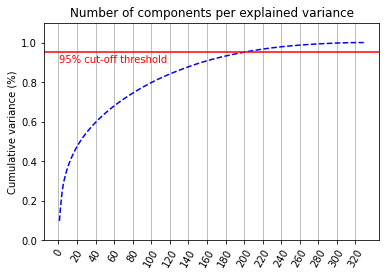

In [21]:
fig, ax = plt.subplots()
xi = np.arange(1, 330, step=1)
y = np.cumsum(pca_fit.explained_variance_ratio_)
plt.ylim(0.0, 1.1)
plt.plot(xi, y, linestyle = '--', color='b')

plt.title('Number of Components')
plt.xticks(np.arange(0, 330, step=20), rotation=60)
plt.ylabel('Cumulative variance (%)')
plt.title('Number of components per explained variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.90, '95% cut-off threshold', color='red')

ax.grid(axis='x')
plt.show()

By the plot, for 95% explained variance, 200 components where the chosen number.

In [16]:
pca = PCA(n_components=200)

In [17]:
pca_azdias = pca.fit_transform(azdias_scaled)

### K-Means Clustering Model

In [33]:
# Creating the K-Means models with k from 3 to 20 and saving the models
for k in range(3, 21):
    print(k)
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_azdias)
    filename=f'kmeans_{k}.pkl'
    pickle.dump(kmeans, open(filename, 'wb'))

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [27]:
BIC = []
for i in range (3, 21):
    kmean = pickle.load(open(f'kmeans_{i}.pkl', 'rb'))
    BIC.append(compute_bic(kmean, pca_azdias))

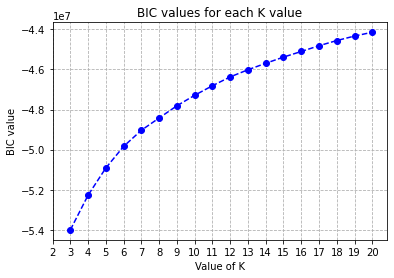

In [31]:
plt.plot(range(3,21), BIC, linestyle='--', marker='o', color='blue')
plt.ylabel('BIC value')
plt.xlabel('Value of K')
plt.title('BIC values for each K value')
plt.grid(linestyle='dashed')
plt.xticks(np.arange(2, 21, step=1))
plt.show()

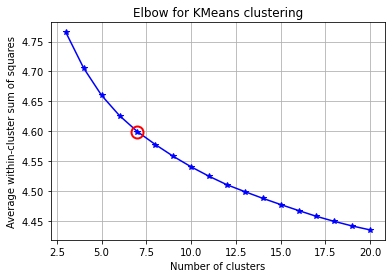

In [18]:
# As firstly both the BIC and Elbow methods were not so clear as to the optimum number of cluster, a threshold of 0.99 was determined and the number of clusters was selected according to the function below

K = range(3,21)
KM = [pickle.load(open(f'kmeans_{k}.pkl', 'rb')) for k in K]
centroids = [k.cluster_centers_ for k in KM]

D_k = [cdist(pca_azdias, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/pca_azdias.shape[0] for d in dist]

# Total with-in sum of squares


seg_threshold = 0.99 #Set this to your desired target

#The angle between three points
def segments_gain(p1, v, p2):
    vp1 = np.linalg.norm(p1 - v)
    vp2 = np.linalg.norm(p2 - v)
    p1p2 = np.linalg.norm(p1 - p2)
    return np.arccos((vp1**2 + vp2**2 - p1p2**2) / (2 * vp1 * vp2)) / np.pi

#Normalize the data
criterion = np.array(avgWithinSS)
criterion = (criterion - criterion.min()) / (criterion.max() - criterion.min())

#Compute the angles
seg_gains = np.array([0, ] + [segments_gain(*
        [np.array([K[j], criterion[j]]) for j in range(i-1, i+2)]
    ) for i in range(len(K) - 2)] + [np.nan, ])

#Get the first index satisfying the threshold
kIdx = np.argmax(seg_gains > seg_threshold)

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')
plt.show()



As BIC did not offer a clear better number, the elbow method suggested 7 clusters

In [51]:
chosen_k = pickle.load(open('kmeans_7.pkl', 'rb'))

In [38]:
general_public = chosen_k.predict(pca_azdias)

In [34]:
per_cluster = pd.Series(geneneral_public).value_counts()

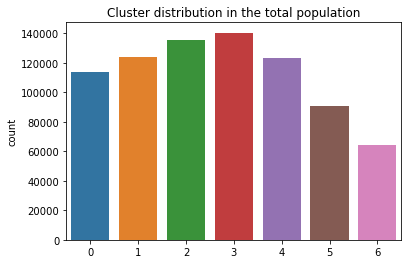

In [40]:
sns.countplot(general_public)
plt.title('Cluster distribution in the total population')
plt.show()

Now getting clusters for the Customers dataset

In [54]:
pca_customers = PCA(n_components=200)

In [45]:
by_product = [customers.loc[customers['PRODUCT_GROUP'] == x].drop(columns=['CUSTOMER_GROUP']) for x in customers['PRODUCT_GROUP'].drop_duplicates()]

In [46]:
by_customer = [customers.loc[customers['CUSTOMER_GROUP'] == x].drop(columns=['PRODUCT_GROUP']) for x in customers['CUSTOMER_GROUP'].drop_duplicates()]

In [47]:
customers = customers.drop(columns=['CUSTOMER_GROUP', 'PRODUCT_GROUP'])

In [49]:
scaler = MinMaxScaler()
customers_scaled=pd.DataFrame(scaler.fit_transform(customers), columns=customers.columns)

In [29]:
clusters_customer = pd.DataFrame()
for data in by_customer:
    label = data[['CUSTOMER_GROUP']]
    data = data.drop(columns=['CUSTOMER_GROUP'])
    pca_loop = PCA(n_components=200)
    data = pca_loop.fit_transform(data)
    clusters = chosen_k.predict(data)
    label['Cluster'] = clusters
    clusters_customer = pd.concat([clusters_customer, label], axis=0)

In [42]:
clusters_product = pd.DataFrame()
for data in by_product:
    label = data[['PRODUCT_GROUP']]
    data = data.drop(columns=['PRODUCT_GROUP'])
    pca_loop = PCA(n_components=200)
    data = pca_loop.fit_transform(data)
    clusters = chosen_k.predict(data)
    label['Cluster'] = clusters
    clusters_product = pd.concat([clusters_product, label], axis=0)

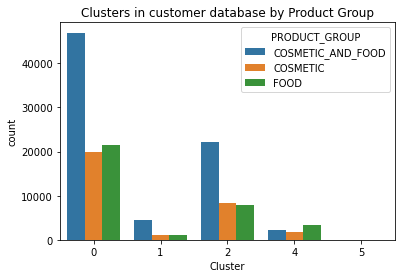

In [38]:
sns.countplot(data=clusters_product, x='Cluster', hue='PRODUCT_GROUP')
plt.title('Clusters in customer database by Product Group')
plt.show()

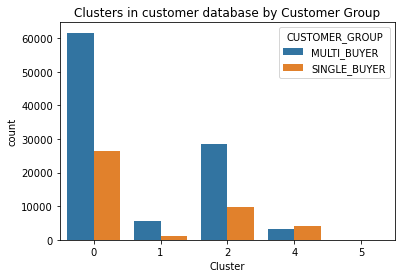

In [43]:
sns.countplot(data=clusters_customer, x='Cluster', hue='CUSTOMER_GROUP')
plt.title('Clusters in customer database by Customer Group')
plt.show()

In [55]:
pca_all_cust = pca_customers.fit_transform(customers)

In [56]:
all_cust = chosen_k.predict(pca_all_cust)

In [45]:
per_cluster_cust = pd.Series(all_cust).value_counts()

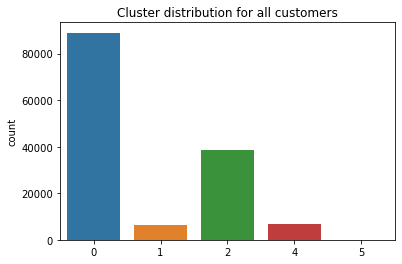

In [68]:
sns.countplot(all_cust)
plt.title('Cluster distribution for all customers')
plt.show()

Interesting to notice, besides the concentration in the clusters 0 and 2, the absence of customers in clusters 3, 5 and 6

In [72]:
proportional_customers = pd.Series(all_cust).value_counts()/len(all_cust)
proportional_all = pd.Series(general_public).value_counts()/len(general_public)

In [73]:
proportional_customers = proportional_customers.reindex(range(0, 7)).fillna(0)

In [77]:
comparison_clusters = pd.DataFrame(index = range(0,7), data = {'General Pop.': proportional_all.values, 'Customers': proportional_customers.values})

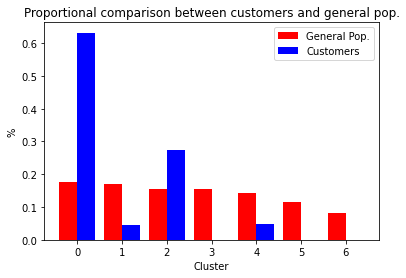

In [96]:
plt.bar(x = [x-0.2 for x in range(0, 7)], height=comparison_clusters['General Pop.'], width = 0.4, align = 'center', label='General Pop.', color='red')
plt.bar(x = [x+0.2 for x in range(0, 7)], height=comparison_clusters['Customers'], width = 0.4, align = 'center', label='Customers', color='blue')
plt.legend()
plt.title('Proportional comparison between customers and general pop.')
plt.xlabel('Cluster')
plt.ylabel('%')
plt.show()

Cluster 0 aggregates most of the customers, while being proportional to other clusters in the general population.
This suggests most customers are from a particular demographic. Now analysing the Cluster 0 and recovering the most influential features.

In [100]:
cluster_0_center = pd.Series(chosen_k.cluster_centers_[0])

In [101]:
cluster_0_center.sort_values(ascending=False)

1     0.640300
2     0.502843
3     0.397619
8     0.174285
4     0.151954
        ...   
10   -0.103721
6    -0.231049
5    -0.251146
9    -0.273797
0    -2.219197
Length: 200, dtype: float64

In [107]:
importances = pd.DataFrame(pca_customers.components_,columns=customers.columns,index = [f'PC-{str(x)}' for x in range(0, 200)]).T

In [111]:
# Features 1, 2 and 3 have the highest positive value, while cluster 0 have a very representative negative value.
importances_cust = importances[['PC-0', 'PC-1', 'PC-2', 'PC-3']]

In [113]:
# Getting the main features for each component
for column in importances_cust.columns:
    feats = ', '.join(list(importances_cust.head(5).index))
    print(f'Main features for {column} are:{feats}\n')
  

Main features for PC-0 are:AKT_DAT_KL, ANZ_HAUSHALTE_AKTIV, ANZ_HH_TITEL, ANZ_KINDER, ANZ_PERSONEN

Main features for PC-1 are:AKT_DAT_KL, ANZ_HAUSHALTE_AKTIV, ANZ_HH_TITEL, ANZ_KINDER, ANZ_PERSONEN

Main features for PC-2 are:AKT_DAT_KL, ANZ_HAUSHALTE_AKTIV, ANZ_HH_TITEL, ANZ_KINDER, ANZ_PERSONEN

Main features for PC-3 are:AKT_DAT_KL, ANZ_HAUSHALTE_AKTIV, ANZ_HH_TITEL, ANZ_KINDER, ANZ_PERSONEN



The main features that define the customers are:

* AKT_DAT_KL: Not present in the Attributes dataset
* ANZ_HAUSHALTE_AKTIV: number of households known in the building
* ANZ_HH_TITEL: number of academic title holder in building
* ANZ_KINDER: number of children in the holsehold (not present in the Attributes Dataset aber Ich verstehe Deutsch)
* ANZ_PERSONEN: number of adult persons in the household

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [37]:
mailout_train = pd.read_csv('./data/mailout_train.csv', sep=',')

In [16]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


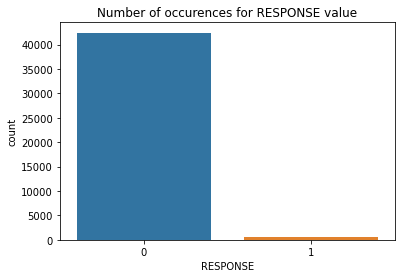

In [40]:
sns.countplot(x=mailout_train['RESPONSE'], data = mailout_train)
plt.title('Number of occurences for RESPONSE value')
plt.show()

In [45]:
perc_positives = (mailout_train['RESPONSE'].sum()/len(mailout_train['RESPONSE'].index)) * 100

In [47]:
print(f'Positive responses correspond to {round(perc_positives, 2)}% of values')

Positive responses correspond to 1.24% of values


In [102]:
# NA values by row
(mailout_train.isna().sum(axis=1)/len(mailout_train.columns)).sort_values(ascending=False).describe()

count    42962.000000
mean         0.191681
std          0.268432
min          0.005450
25%          0.049046
50%          0.065395
75%          0.087193
max          0.765668
dtype: float64

In [48]:
mailout_train['EINGEFUEGT_AM'].head()

0    1992-02-10 00:00:00
1    1997-05-14 00:00:00
2    1995-05-24 00:00:00
3    1992-02-10 00:00:00
4    1992-02-10 00:00:00
Name: EINGEFUEGT_AM, dtype: object

In [96]:
# Printing non-numeric columns to check with known values
mailout_train[list(mailout_train.dtypes.sort_values().tail(6).index)].nunique()

D19_LETZTER_KAUF_BRANCHE      35
CAMEO_DEU_2015                45
CAMEO_DEUG_2015               19
CAMEO_INTL_2015               43
EINGEFUEGT_AM               1599
OST_WEST_KZ                    2
dtype: int64

In [49]:

def pre_process_supervised(df: pd.DataFrame, attributes: pd.DataFrame, train:bool=True) -> pd.DataFrame:

    '''
    This function apply the preprocessing steps in the training and test data, adding dummies and using previous
    k-means model as a feature for the dataframe.

    Arguments:
    df: raw dataframe
    attributes: attributes dataframe
    train: flag for training data. If false will not drop any rows

    Returns:
    preprocessed dataframe
    '''

    attribute_na = get_unknown(attributes)


    columns_keep = []
    for column in df.columns:
        na_values = attribute_na.loc[attribute_na['Attribute'] == column, 'Value'].values
        df.loc[df[column].isin(na_values), column] = np.NaN
        if (df[column].isna().sum()/len(df[column])) <= 0.29:
            columns_keep.append(column)

    df = df[columns_keep]
    df.drop(columns = ['EINGEFUEGT_AM',  'LNR'], inplace = True)

    if train:
        df['cut_row'] = df.isna().sum(axis=1)/df.shape[1]
        df = df.loc[df['cut_row'] <= 0.73]
        df.drop(columns = ['cut_row'], inplace=True)
    

    for column in ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']:
        df[column] = pd.to_numeric(df[column], errors='coerce')

    ost_west_dict = {'W': 0, 'O': 1}
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map(ost_west_dict)

    df = pd.get_dummies(df, columns=['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE'], dummy_na=True)
    
    df = fill_bool(df,df)
    df = fill_num(df, df)

    # Add cluster for each line

    scaler = MinMaxScaler()
    df_scaled = df[list(azdias)]
    df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled), columns=df_scaled.columns)
    pca = PCA(n_components=200)
    df_scaled = pca.fit_transform(df_scaled)
    clusters = chosen_k.predict(df_scaled)
    del df_scaled, scaler, pca
    df['CLUSTER'] = clusters
    df = pd.get_dummies(df, columns=['CLUSTER'])
    
    if train:
        # put RESPONSE column last
        ordered_columns = list(df.columns)
        ordered_columns.remove('RESPONSE')
        ordered_columns = ['RESPONSE'] + ordered_columns
        df = df[ordered_columns]


    return df 

In [52]:
mailout_train_treated = pre_process_supervised(mailout_train, attributes)

In [20]:
mailout_train_treated.isna().sum().max()

0

In [73]:
(len(mailout_train_treated.index)-mailout_train_treated['RESPONSE'].sum())/mailout_train_treated['RESPONSE'].sum()

79.15590200445435

In [23]:
mailout_train_treated.shape

(35990, 421)

In [28]:
# Adding a model list to try different models
 
model_list = []
model_list.append(('LR',LogisticRegression()))
model_list.append(('GBM', GradientBoostingClassifier()))
model_list.append(('RFR', RandomForestClassifier()))
model_list.append(('XGB', XGBClassifier(objective='binary:logistic')))
model_list.append(('LGB', LGBMClassifier()))
model_list.append(('CAT', CatBoostClassifier(verbose=0)))


In [53]:
X = mailout_train_treated.iloc[:, 1:]
y = mailout_train_treated.iloc[:, 0]

In [30]:
results = []
names = []
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
for name, model in model_list:
    model_try = model
    n_scores = cross_val_score(model_try, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    msg = "ROC_AUC for %s: %.3f (%.3f)" % (name, np.mean(n_scores), np.std(n_scores))
    names.append(name)
    results.append(n_scores)

    print(msg)

ROC_AUC for LR: 0.690 (0.020)
ROC_AUC for GBM: 0.771 (0.019)
ROC_AUC for RFR: 0.605 (0.023)
ROC_AUC for XGB: 0.740 (0.022)
ROC_AUC for LGB: 0.755 (0.023)
ROC_AUC for CAT: 0.774 (0.021)


In [31]:
dict_res = {}
for i in range(0,6):
    dict_res[names[i]] = results[i]

In [32]:
data_res = pd.DataFrame(dict_res)

In [33]:
data_res = data_res.stack().reset_index().rename(columns={'level_1':'Model', 0: 'ROC_AUC'}).drop(columns='level_0')

In [34]:
data_res.rename(columns={0:'ROC_AUC'}, inplace=True)

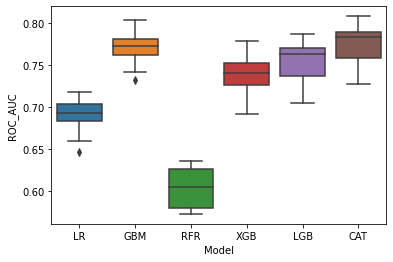

In [35]:
sns.boxplot(x="Model", y="ROC_AUC", data=data_res)
plt.show()

### Using SMOTE to deal with unbalanced data

In [38]:
results = []
names = []
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
for name, model in model_list:
    model_try = model

    over = SMOTE(sampling_strategy=0.1, k_neighbors = 7) # with only oversampling
    steps = [('over', over), ('model', model_try)]
    pipeline = Pipeline(steps=steps)

    n_scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    msg = "ROC_AUC for %s: %.3f (%.3f)" % (name, np.mean(n_scores), np.std(n_scores))
    names.append(name)
    results.append(n_scores)

    print(msg)

ROC_AUC for LR: 0.683 (0.021)
ROC_AUC for GBM: 0.779 (0.020)
ROC_AUC for RFR: 0.601 (0.035)
ROC_AUC for XGB: 0.739 (0.023)
ROC_AUC for LGB: 0.768 (0.019)
ROC_AUC for CAT: 0.773 (0.023)


In [40]:
results = []
names = []
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
for name, model in model_list:
    model_try = model

    over = SMOTE(sampling_strategy=0.2, k_neighbors = 7) 
    under = RandomUnderSampler(sampling_strategy=0.8) #adding undersampling
    steps = [('over', over), ('under', under), ('model', model_try)]
    pipeline = Pipeline(steps=steps)

    n_scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    msg = "ROC_AUC for %s: %.3f (%.3f)" % (name, np.mean(n_scores), np.std(n_scores))
    names.append(name)
    results.append(n_scores)

    print(msg)

ROC_AUC for LR: 0.685 (0.017)
ROC_AUC for GBM: 0.770 (0.021)
ROC_AUC for RFR: 0.682 (0.019)
ROC_AUC for XGB: 0.741 (0.012)
ROC_AUC for LGB: 0.769 (0.021)
ROC_AUC for CAT: 0.767 (0.026)


In [41]:

results = []
names = []
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
for name, model in model_list:
    model_try = model

    over = SMOTE(sampling_strategy=0.25, k_neighbors = 5) # changing SMOTE parameters
    under = RandomUnderSampler(sampling_strategy=0.85)
    steps = [('over', over), ('under', under), ('model', model_try)]
    pipeline = Pipeline(steps=steps)

    n_scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    msg = "ROC_AUC for %s: %.3f (%.3f)" % (name, np.mean(n_scores), np.std(n_scores))
    names.append(name)
    results.append(n_scores)

    print(msg)

ROC_AUC for LR: 0.682 (0.022)
ROC_AUC for GBM: 0.773 (0.019)
ROC_AUC for RFR: 0.674 (0.021)
ROC_AUC for XGB: 0.741 (0.017)
ROC_AUC for LGB: 0.764 (0.022)
ROC_AUC for CAT: 0.767 (0.020)


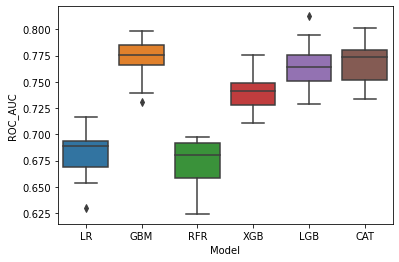

In [42]:
dict_res = {}
for i in range(0,6):
    dict_res[names[i]] = results[i]

data_res = pd.DataFrame(dict_res)

data_res = data_res.stack().reset_index().rename(columns={'level_1':'Model', 0: 'ROC_AUC'}).drop(columns='level_0')

data_res.rename(columns={0:'ROC_AUC'}, inplace=True)

sns.boxplot(x="Model", y="ROC_AUC", data=data_res)
plt.show()

### Hyperparameter optimization

In [24]:
# Implementing early stopping

OPTUNA_EARLY_STOPPING = 150

class EarlyStoppingExceeded(optuna.exceptions.OptunaError):
    ''' this class inherits from OptunaError to make a custom EarlyStopping'''
    early_stop = OPTUNA_EARLY_STOPPING
    early_stop_count = 0
    best_score = None


def early_stopping_opt(study, trial):
    ''' This function creates a callback for the Optuna study'''

    if EarlyStoppingExceeded.best_score == None:
        EarlyStoppingExceeded.best_score = study.best_value

    if study.best_value < EarlyStoppingExceeded.best_score:
        EarlyStoppingExceeded.best_score = study.best_value
        EarlyStoppingExceeded.early_stop_count = 0
    else:
        if EarlyStoppingExceeded.early_stop_count > EarlyStoppingExceeded.early_stop:
            EarlyStoppingExceeded.early_stop_count = 0
            best_score = None
            raise EarlyStoppingExceeded()
        else:
            EarlyStoppingExceeded.early_stop_count=EarlyStoppingExceeded.early_stop_count+1

    return

In [22]:
def objective(trial):

    ''' The objetive function for Optuna to optimize '''

    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    model_type = trial.suggest_categorical('model_type', ['catboost', 'lightgbm', 'gradientboost'])

    if model_type == 'catboost':
        param = {
            "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
            "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
            "depth": trial.suggest_int("depth", 1, 12),
            "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
            "bootstrap_type": trial.suggest_categorical(
                "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
            ),
            "used_ram_limit": "4gb",
        }

        if param["bootstrap_type"] == "Bayesian":
            param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
        elif param["bootstrap_type"] == "Bernoulli":
            param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

        classifier_obj = CatBoostClassifier(**param)

    elif model_type == 'lightgbm':
        param = {
            'objective': 'binary',
            'metric': 'binary_logloss',
            'verbosity': -1,
            'boosting_type': 'gbdt',
            'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
            'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
            'num_leaves': trial.suggest_int('num_leaves', 2, 256),
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
            'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        }

        classifier_obj = LGBMClassifier(**param)
    
    else:
        param= {'n_estimators': trial.suggest_int('n_estimators', 50, 1500),
                'max_features': trial.suggest_categorical('max_features', \
                ['auto', 'sqrt', 'log2']),
                'max_depth': trial.suggest_int('max_depth', 3, 20),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5)
                }
        classifier_obj = GradientBoostingClassifier(**param)
    
    score = cross_val_score(classifier_obj, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    return np.mean(score)

In [23]:
study = optuna.create_study(direction='maximize')
try:
    study.optimize(objective, n_trials=750, n_jobs=-1, callbacks=[early_stopping_opt])
except EarlyStoppingExceeded:
    print('EarlyStopping Exceeded: No new best scores after 150 iterations')

trial = study.best_trial

[I 2021-02-21 12:30:56,785] A new study created in memory with name: no-name-5415f79d-4e83-4858-8fb7-0ebdcf627827
[I 2021-02-21 12:49:47,758] Trial 3 finished with value: 0.7288676950180529 and parameters: {'n_estimators': 1095, 'max_features': 'log2', 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.7288676950180529.
[I 2021-02-21 12:50:33,064] Trial 1 finished with value: 0.7391171849490229 and parameters: {'n_estimators': 587, 'max_features': 'sqrt', 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.7391171849490229.
[I 2021-02-21 13:16:35,242] Trial 6 finished with value: 0.7357396821306621 and parameters: {'n_estimators': 1124, 'max_features': 'log2', 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.7391171849490229.
[I 2021-02-21 13:47:58,959] Trial 0 finished with value: 0.6857072505756759 and parameters: {'n_estimators': 1241, 'max_features': '

KeyboardInterrupt: 

This first study could be promissing, but each iteration was taking to long, so the approach changed

### New optimization approach

In [54]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

In [25]:
def objective(trial):

    ''' The objetive function for Optuna to optimize '''
   

    param = {
        "verbose": 0,
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "1gb",
            }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    classifier_obj = CatBoostClassifier(**param)

    
   
    
    model_try = classifier_obj.fit(X_train, y_train)

    return roc_auc_score(y_valid, model_try.predict(X_valid))

In [26]:
study = optuna.create_study(direction='maximize')
try:
    study.optimize(objective, n_trials=750, n_jobs=-1, callbacks=[early_stopping_opt])
except EarlyStoppingExceeded:
    print('EarlyStopping Exceeded: No new best scores after 100 iterations')

trial = study.best_trial

ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(26992) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(26992) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(26992) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(26992) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(26992) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(26992) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(26992) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(26992) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(26992) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(26992) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(26992) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(2

Catboost did not reach a better roc_auc_score so the other models were tried

In [ ]:
def objective(trial):

    ''' The objetive function for Optuna to optimize '''

    
    model_type = trial.suggest_categorical('model_type', ['lightgbm', 'gradientboost'])
    
    
    
    
    if model_type == 'lightgbm':
        param = {
            'objective': 'binary',
            'metric': 'binary_logloss',
            'verbosity': -1,
            'boosting_type': 'gbdt',
            'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
            'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
            'num_leaves': trial.suggest_int('num_leaves', 2, 256),
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
            'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        }

        classifier_obj = LGBMClassifier(**param)
    
    else:
        param= {'n_estimators': trial.suggest_int('n_estimators', 50, 1500),
                'max_features': trial.suggest_categorical('max_features', \
                ['auto', 'sqrt', 'log2']),
                'max_depth': trial.suggest_int('max_depth', 3, 20),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5)
                }
        classifier_obj = GradientBoostingClassifier(**param)

    
    model_try = classifier_obj.fit(X_train, y_train)

    return roc_auc_score(y_valid, model_try.predict(X_valid))

In [ ]:
study = optuna.create_study(direction='maximize')
try:
    study.optimize(objective, n_trials=750, n_jobs=-1, callbacks=[early_stopping_opt])
except EarlyStoppingExceeded:
    print('EarlyStopping Exceeded: No new best scores after 100 iterations')

trial = study.best_trial

In [60]:
trial.params

{'model_type': 'lightgbm',
 'lambda_l1': 0.023595797435052576,
 'lambda_l2': 0.10444065712521429,
 'num_leaves': 2,
 'feature_fraction': 0.9228058648353306,
 'bagging_fraction': 0.7627300352038621,
 'bagging_freq': 7,
 'min_child_samples': 13,
 'scale_pos_weight': 83.54634055886325}

In [55]:
final_params = {'lambda_l1': 0.023595797435052576,
 'lambda_l2': 0.10444065712521429,
 'num_leaves': 2,
 'feature_fraction': 0.9228058648353306,
 'bagging_fraction': 0.7627300352038621,
 'bagging_freq': 7,
 'min_child_samples': 13,
 'scale_pos_weight': 83.54634055886325}

In [60]:
chosen_model = LGBMClassifier(**final_params)

In [61]:
chosen_model.fit(X_train, y_train)

[LightGBM] [Warning] lambda_l1 is set=0.023595797435052576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.023595797435052576
[LightGBM] [Warning] bagging_fraction is set=0.7627300352038621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7627300352038621
[LightGBM] [Warning] lambda_l2 is set=0.10444065712521429, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10444065712521429
[LightGBM] [Warning] feature_fraction is set=0.9228058648353306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9228058648353306
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


LGBMClassifier(bagging_fraction=0.7627300352038621, bagging_freq=7,
               feature_fraction=0.9228058648353306,
               lambda_l1=0.023595797435052576, lambda_l2=0.10444065712521429,
               min_child_samples=13, num_leaves=2,
               scale_pos_weight=83.54634055886325)

In [62]:
roc_auc_score(y_valid, chosen_model.predict(X_valid))

0.7919747431786953

The model reached 79.2% in the validation dataset with predict

In [66]:
from sklearn.metrics import roc_curve

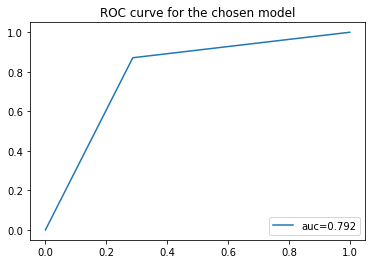

In [70]:
pred_valid = chosen_model.predict(X_valid)

fpr, tpr, _ = roc_curve(y_valid,  pred_valid)
auc = roc_auc_score(y_valid, pred_valid)
plt.plot(fpr, tpr, label="auc="+str(round(auc,3)))
plt.legend(loc=4)
plt.title('ROC curve for the chosen model')
plt.show()

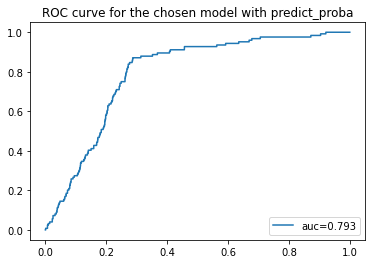

In [71]:
pred_valid = chosen_model.predict_proba(X_valid)[:,1]

fpr, tpr, _ = roc_curve(y_valid,  pred_valid)
auc = roc_auc_score(y_valid, pred_valid)
plt.plot(fpr, tpr, label="auc="+str(round(auc,3)))
plt.legend(loc=4)
plt.title('ROC curve for the chosen model with predict_proba')
plt.show()

## Generating submission file for the Kaggle competition

In [22]:
mailout_test = pd.read_csv('./data/mailout_test.csv', sep=',')

In [29]:
submission = mailout_test[['LNR']].copy()

In [24]:
mailout_test_treated = pre_process_supervised(mailout_test, attributes = attributes,train=False)

In [80]:
predicted_values = chosen_model.predict_proba(mailout_test_treated)

In [83]:
submission['RESPONSE'] = predicted_values[:,1]

In [38]:
submission['LNR'] = submission['LNR'].astype(np.int32)

In [84]:
submission.to_csv('./submissions/submission.csv', index=False)

In [85]:
submission

,LNR,RESPONSE
0,1754,0.279168
1,1770,0.221097
2,1465,0.031015
3,1470,0.016725
4,1478,0.029293
...,...,...
42828,67615,0.047295
42829,67938,0.044639
42830,67942,0.159039
42831,67949,0.157404
